<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/cleansed/kk_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
===================================================
Author: Kasia Kirby
Role: Reporting Lead, Bank of England Employer Project (Quant Collective)
LinkedIn: https://www.linkedin.com/in/kasia-kirby
Date: 2025-02-18
Version: 1.0

Description:
    This notebook conducts descriptive analysis on the preprocessed earnings calls transcript data
    to understand its characteristics (e.g., text length, word frequency)
    and generate visualisations (word clouds, histograms) to highlight trends or anomalies.

===================================================
"""

'\n===================================================\nAuthor: Kasia Kirby\nRole: Reporting Lead, Bank of England Employer Project (Quant Collective)\nLinkedIn: https://www.linkedin.com/in/kasia-kirby\nDate: 2025-02-13\nVersion: 1.0\n\nDescription:\n    This notebook conducts descriptive analysis on the preprocessed earnings calls transcript data\n    to understand its characteristics (e.g., text length, word frequency)\n    and generate visualisations (word clouds, histograms) to highlight trends or anomalies.\n\n===================================================\n'

# 0. Summarised, actionable findings based on EDA performed below

**JP Morgan Earnings Call EDA Summary & Modelling Considerations**

1️⃣ Preprocessing Considerations

- **Ensure speaker roles and segmentation are preserved**—CFO contributions dominate word count, especially in lower sentiment quarters, while CEO presence fluctuates.
- **Q&A segmentation is critical**—analyst questions tend to have lower sentiment than executive answers, which may impact topic clustering.
- **Management discussion sentiment appears inflated (~1.0 constant)**—consider handling separately to avoid biasing FinBERT sentiment analysis.
- **Filtering out operator dialogue** and very short responses (e.g., “thank you”) will reduce noise in topic modelling (please see more detail in the attached notebook)

2️⃣ Topic Modelling (BERTopic & LLMs)

- BERTopic should differentiate between **analyst-driven concerns (questions) and executive messaging (answers)** to extract distinct themes.
- ❗**Q24 warrants special focus**—CFO spoke significantly more despite lower sentiment, possibly addressing financial concerns or regulatory scrutiny.
- Executive-driven topics may shift **between reassurance (positive sentiment, high CEO input) and defense (negative sentiment, high CFO input)**—look for trend shifts in clustering.
- **Common bigrams & trigrams** include financial-specific phrases (“net income,” “year-on-year driven”)—these should be **retained in vectorization to preserve context.** (please see more detail in the attached notebook)

3️⃣ Sentiment Modelling (FinBERT & Advanced LLMs)

- **Questions & answers should be analyzed separately**—answers generally have higher sentiment, meaning aggregated sentiment may obscure analyst skepticism.
- **FinBERT should test sentiment divergence** between **questioning analysts vs. responding executives**, particularly in lower sentiment quarters.
- ❗**Look for sentiment mismatches in high-word-count quarters**—e.g., 2Q24 had high word count despite low sentiment, indicating defensive language.
- **Avoid over-reliance on average sentiment scores**—outliers (e.g., particularly negative questions) may provide more signal than mean sentiment alone.

4️⃣ Final Considerations for Further Analysis

- Further investigation needed into **macroeconomic event alignments**, especially in **1Q23, 2Q24, and 4Q24**, where sentiment deviated unexpectedly.
- Consider cross-checking **analyst participation levels**—does lower sentiment correlate with more probing or confrontational analyst engagement?
- **If applying summarization (e.g., GPT-based)**, ensure that Q&A is kept **structured** to retain speaker intent, rather than blending all responses into a single summary.

Implement topic modelling & sentiment analysis with the above preprocessing refinements.

# 1. Import libraries and files

Note: I will start with JPM data for each quarter between 2023-2024.

I have listened to the Q42024 call. My impressions from the call (I do not have investment finance experience)
* Overall positive sentiment.
* 'We remain optimistic' theme across the call.
* Good investments have returned good returns overall.
* CEO leaves in 5 years (mentioned health problems).
* JPM is driving efficiencies in developer departments as part of long term, holistic practice.
* Key vulnerability same as for everyone else: unemployment rates that drive credit.

In [ ]:
!pip install nltk

In [ ]:
import os
import sys
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import islice
from nltk.util import ngrams
from wordcloud import WordCloud
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
# Mount Google Drive to the root location
drive.mount('/content/drive', force_remount=True)
BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'
print(os.listdir(BOE_path))

Mounted at /content/drive
['ubs_management_discussion_preprocessed.csv', 'ubs_qna_df_preprocessed.csv', 'Archived', 'JP Mogran processed thru OpenAI', 'jpmorgan_qna_df_preprocessed_final.csv', 'jpmorgan_management_df_preprocessed_final.csv']


In [ ]:
# Load JPM preprocessed transcripts

files = os.listdir(BOE_path)

jp_morgan_files = [
    'jpmorgan_qna_df_preprocessed_final.csv',
    'jpmorgan_management_df_preprocessed_final.csv',
]

for file in jp_morgan_files:
    file_path = os.path.join(BOE_path, file)

    try:
        df = pd.read_csv(file_path, nrows=5)
        print(f"\n📌 **File: {file}**")
        print(df.columns.tolist())
    except Exception as e:
        print(f"\n⚠️ Could not read {file}: {e}")


📌 **File: jpmorgan_qna_df_preprocessed_final.csv**
['Index', 'Quarter-Year', 'Question', 'Question_cleaned', 'Asked By', 'Role of the person asked the question', 'Answer', 'Answer_cleaned', 'Answered By', 'Role of the person answered the question']

📌 **File: jpmorgan_management_df_preprocessed_final.csv**
['Index', 'Quarter-Year', 'Text', 'Text_cleaned']


Steps below are to help us
- **assess data quality**
- **understand text characteristics**
- **identify anomalies before further analysis**

# 2. Analyse data structure & text length

🔎 Missing Values in Q&A Data:
 Index                                       0
Quarter-Year                                0
Question                                    1
Question_cleaned                            0
Asked By                                    1
Role of the person asked the question       1
Answer                                      2
Answer_cleaned                              0
Answered By                                 2
Role of the person answered the question    2
dtype: int64

🔎 Missing Values in Management Discussion Data:
 Index           8
Quarter-Year    0
Text            0
Text_cleaned    0
dtype: int64


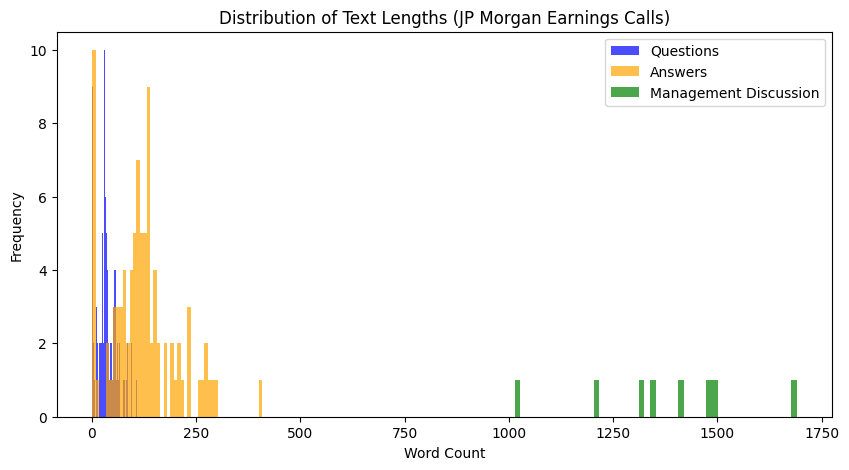


📌 Summary Statistics:
Q&A Questions: count     91.000000
mean      38.252747
std       25.052209
min        1.000000
25%       24.500000
50%       34.000000
75%       54.000000
max      112.000000
Name: question_word_count, dtype: float64
Q&A Answers: count     91.000000
mean     123.131868
std       79.252930
min        1.000000
25%       75.000000
50%      116.000000
75%      152.500000
max      409.000000
Name: answer_word_count, dtype: float64
Management Discussion: count       8.000000
mean     1371.625000
std       203.431236
min      1014.000000
25%      1287.000000
50%      1383.500000
75%      1486.000000
max      1690.000000
Name: text_word_count, dtype: float64


In [ ]:
# Check missing values, text length distribution, and compare response length trends

qna_df = pd.read_csv(f"{BOE_path}/jpmorgan_qna_df_preprocessed_final.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_df_preprocessed_final.csv")

# Check for missing values
print("🔎 Missing Values in Q&A Data:\n", qna_df.isnull().sum())
print("\n🔎 Missing Values in Management Discussion Data:\n", management_df.isnull().sum())

# Compute word counts
qna_df["question_word_count"] = qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split()))
qna_df["answer_word_count"] = qna_df["Answer_cleaned"].astype(str).apply(lambda x: len(x.split()))
management_df["text_word_count"] = management_df["Text_cleaned"].astype(str).apply(lambda x: len(x.split()))

# Plot word count distribution
plt.figure(figsize=(10, 5))
plt.hist(qna_df["question_word_count"], bins=50, alpha=0.7, label="Questions", color='blue')
plt.hist(qna_df["answer_word_count"], bins=50, alpha=0.7, label="Answers", color='orange')
plt.hist(management_df["text_word_count"], bins=50, alpha=0.7, label="Management Discussion", color='green')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths (JP Morgan Earnings Calls)")
plt.legend()
plt.show()

# Summary statistics
print("\n📌 Summary Statistics:")
print("Q&A Questions:", qna_df["question_word_count"].describe())
print("Q&A Answers:", qna_df["answer_word_count"].describe())
print("Management Discussion:", management_df["text_word_count"].describe())

- ❗**Minor missing values to be cleaned up (manual check revealed there is one row of data that separates 2023-2024 but is otherwise empty, also one question "Are you there?" with no answer - these are most likely the culprits, and it should be fine to remove them)**
- 💡Text length distribution - some answers are very short and more data cleaning could be done here (examples printed below)
- 💡Summary statistics - The average question length is ~38 words, while the average answer is ~123 words, confirming that executives provide detailed responses to analyst questions. Q&A responses show high variability (std = 79 words), meaning some answers are much longer than others.

In [ ]:
# Print examples of short answers (fewer than 5 words)

short_answers = qna_df[qna_df["answer_word_count"] < 5][["Answer_cleaned", "Answered By", "Quarter-Year"]]

print(" Examples of Very Short Answers:\n")
print(short_answers.head(10))

 Examples of Very Short Answers:

                    Answer_cleaned    Answered By Quarter-Year
11  ['excellent folks thank much']    Jamie Dimon         1Q23
17                         ['nan']            NaN         2Q23
25              ['thank you guys']    Jamie Dimon         2Q23
37                  ['thank much']    Jamie Dimon         3Q23
48   ['okay thanks much everyone']  Jeremy Barnum         4Q23
54                         ['nan']            NaN         1Q24


❗**Most short answers are polite phrases (e.g., "thank you guys", "okay thanks much everyone"), which are not substantive responses. Exclude these from topic modeling & sentiment analysis to avoid skewed results.**

# 3. Get word frequency & key themes

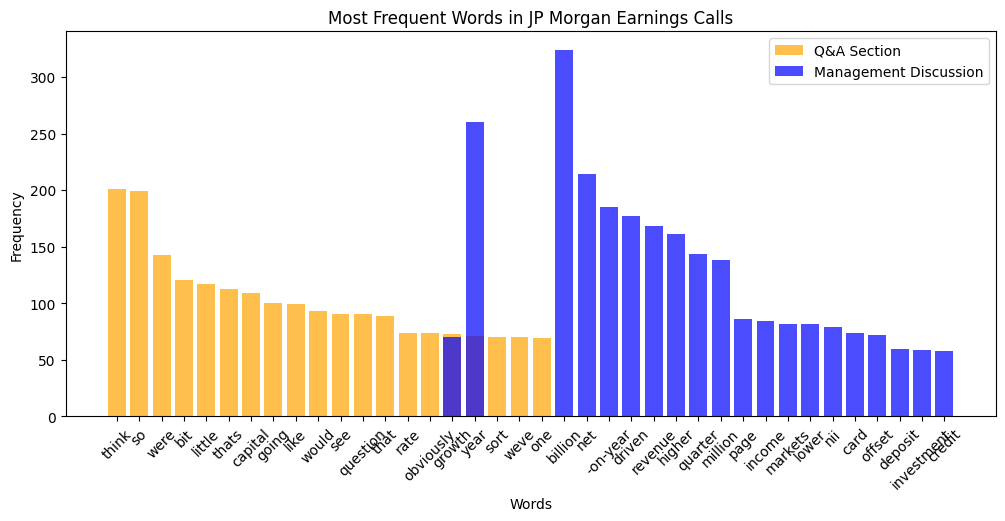

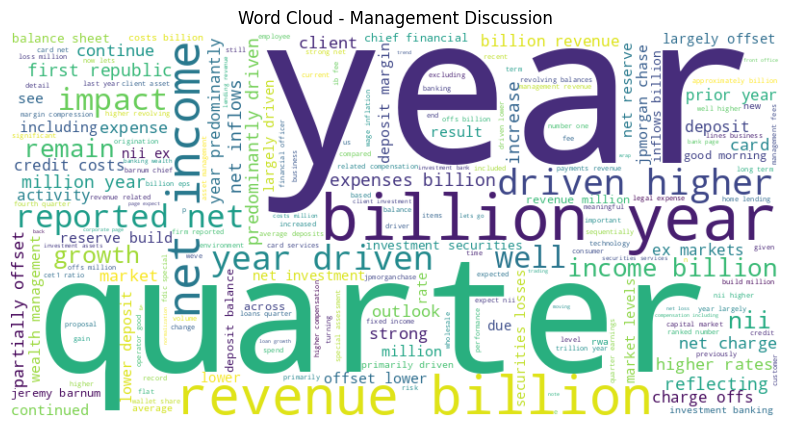

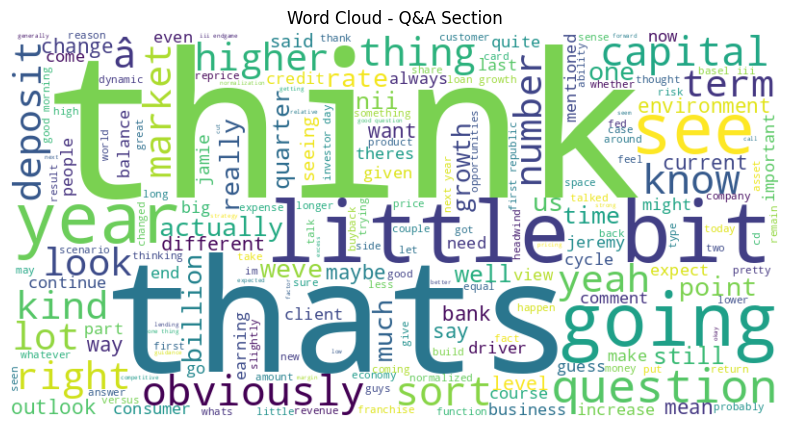


🔎 Top Bigrams in Q&A:
 [(('little', 'bit'), 95), (('loan', 'growth'), 23), (('were', 'going'), 20), (('basel', 'iii'), 19), (('first', 'republic'), 18), (('investor', 'day'), 17), (('so', 'think'), 17), (('good', 'morning'), 15), (('next', 'year'), 15), (('iii', 'endgame'), 15), (('else', 'equal'), 15), (('so', 'thats'), 12), (('rate', 'paid'), 12), (('good', 'question'), 12), (('yield', 'curve'), 12)]

🔎 Top Bigrams in Management Discussion:
 [(('year', '-on-year'), 185), (('net', 'income'), 61), (('driven', 'higher'), 60), (('reported', 'net'), 46), (('-on-year', 'driven'), 42), (('predominantly', 'driven'), 37), (('net', 'inflows'), 37), (('first', 'republic'), 37), (('partially', 'offset'), 32), (('higher', 'rates'), 31), (('net', 'charge'), 30), (('billion', 'revenue'), 28), (('credit', 'costs'), 27), (('ex', 'markets'), 26), (('quarter', '-on-quarter'), 25)]

🔎 Top Trigrams in Q&A:
 [(('basel', 'iii', 'endgame'), 15), (("['hey", 'good', 'morning'), 9), (('net', 'interest', 'inco

In [ ]:
# Extract most common words, frequent financial phrases, compare Q&A and management topics

qna_df = pd.read_csv(f"{BOE_path}/jpmorgan_qna_df_preprocessed_final.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_df_preprocessed_final.csv")

# concatenate text for analysis
qna_text = ' '.join(qna_df["Question_cleaned"].dropna()) + ' ' + ' '.join(qna_df["Answer_cleaned"].dropna())
management_text = ' '.join(management_df["Text_cleaned"].dropna())

# function to get most common words
def get_most_common_words(text, top_n=20):
    words = text.split()
    word_freq = Counter(words)
    return word_freq.most_common(top_n)

# function to generate and count n-grams
def get_most_common_ngrams(text, n=2, top_n=15):
    words = text.split()
    ngram_list = list(ngrams(words, n))
    ngram_freq = Counter(ngram_list)
    return ngram_freq.most_common(top_n)

# get word frequencies
top_words_qna = get_most_common_words(qna_text)
top_words_mgmt = get_most_common_words(management_text)

# get bigrams & trigrams
top_bigrams_qna = get_most_common_ngrams(qna_text, n=2)
top_bigrams_mgmt = get_most_common_ngrams(management_text, n=2)
top_trigrams_qna = get_most_common_ngrams(qna_text, n=3)
top_trigrams_mgmt = get_most_common_ngrams(management_text, n=3)

# convert to df for visualization
df_qna_words = pd.DataFrame(top_words_qna, columns=['Word', 'Frequency'])
df_mgmt_words = pd.DataFrame(top_words_mgmt, columns=['Word', 'Frequency'])

# plot most common words
plt.figure(figsize=(12, 5))
plt.bar(df_qna_words['Word'], df_qna_words['Frequency'], alpha=0.7, label='Q&A Section', color='orange')
plt.bar(df_mgmt_words['Word'], df_mgmt_words['Frequency'], alpha=0.7, label='Management Discussion', color='blue')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in JP Morgan Earnings Calls")
plt.legend()
plt.show()

# word cloud for management discussion
wordcloud_mgmt = WordCloud(width=800, height=400, background_color='white').generate(management_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_mgmt, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Management Discussion")
plt.show()

# word cloud for q&A section
wordcloud_qa = WordCloud(width=800, height=400, background_color='white').generate(qna_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_qa, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Q&A Section")
plt.show()

# print top bigrams & trigrams
print("\n🔎 Top Bigrams in Q&A:\n", top_bigrams_qna)
print("\n🔎 Top Bigrams in Management Discussion:\n", top_bigrams_mgmt)
print("\n🔎 Top Trigrams in Q&A:\n", top_trigrams_qna)
print("\n🔎 Top Trigrams in Management Discussion:\n", top_trigrams_mgmt)

- Management Discussion is dominated by terms like "billion," "revenue," "net income," and "quarter", reflecting structured reporting of financial results. Q&A Section contains conversational fillers like "think," "sort of," "little bit," alongside financial terms ("capital," "market," "growth"), suggesting a mix of informal discussion and analysis-driven questioning.

- Q&A bigrams highlight regulatory and business concerns, such as **"Basel III," "loan growth," "yield curve,"** showing analyst focus on compliance and market conditions. Management Discussion bigrams are metric-focused, with phrases like **"year-on-year," "net income," "reported net"**, reinforcing structured financial disclosures.

- Q&A trigrams contain many greetings (e.g., "good morning Jeremy", "yeah good question"), but also regulatory and risk-related terms (**"Basel III endgame," "net interest income," "stress capital buffer"**). Management Discussion trigrams focus on performance metrics, with structured phrases like **"reported net income," "net charge-offs," "year-on-year driven"**, reinforcing earnings results.

❗**Remove non-informative filler words (e.g., "think," "little bit," "obviously") and greetings from Q&A.**

❗**Use extracted bigrams/trigrams to guide topic modeling - Analysts’ emphasis on Basel III and loan growth suggests these may be critical topics worth segmenting, alongside risk-related phrases ("stress capital buffer," "weighted average rate") which may indicate topics of heightened market concern.**

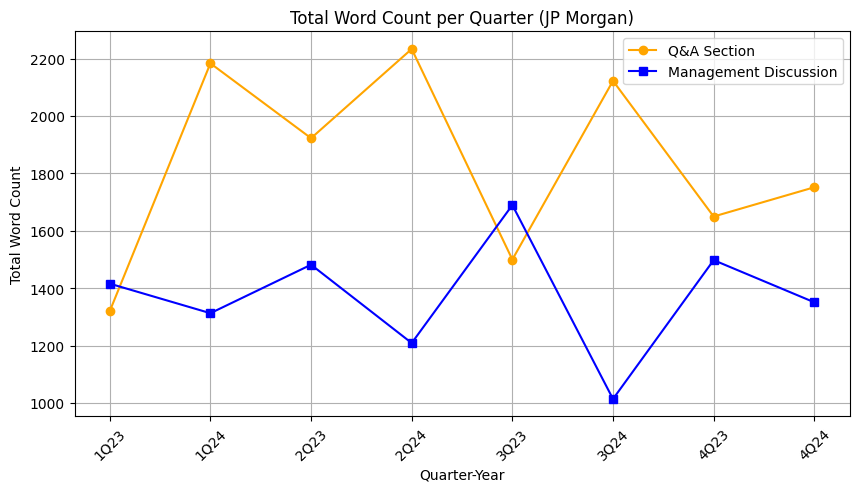

In [ ]:
# Check word count per quarter (Q&A and Management)

qna_df = pd.read_csv(f"{BOE_path}/jpmorgan_qna_df_preprocessed_final.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_df_preprocessed_final.csv")

# compute total word count
qna_df["qna_word_count"] = qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split())) + \
                           qna_df["Answer_cleaned"].astype(str).apply(lambda x: len(x.split()))
management_df["text_word_count"] = management_df["Text_cleaned"].astype(str).apply(lambda x: len(x.split()))

qna_word_count = qna_df.groupby("Quarter-Year")["qna_word_count"].sum().reset_index()
management_word_count = management_df.groupby("Quarter-Year")["text_word_count"].sum().reset_index()

# plot word count trends over time
plt.figure(figsize=(10, 5))
plt.plot(qna_word_count["Quarter-Year"], qna_word_count["qna_word_count"], marker="o", label="Q&A Section", color="orange")
plt.plot(management_word_count["Quarter-Year"], management_word_count["text_word_count"], marker="s", label="Management Discussion", color="blue")
plt.xlabel("Quarter-Year")
plt.ylabel("Total Word Count")
plt.title("Total Word Count per Quarter (JP Morgan)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

- Q&A sections are significantly longer than management discussions, most of the time (this reinforces that earnings calls are heavily shaped by analyst-executive interactions rather than structured statements)
- Noticeable Q&A peaks in 1Q24 and 2Q24 followed by a sharp drop in 3Q23 (suggesting **more extended discussions or detailed responses, which may correspond to earnings surprises, major financial events, or increased analyst scrutiny, followed by dips possibly linked to quieter earnings seasons or fewer unexpected developments**)
- Management dip in 3Q24 followed by a slight rebound suggests a possible seasonal effect or reporting structure shift.

(I checked for macroeconomic events around the 3Q23 dip and there was economic stagnation in the UK (zero growth) with elevated corporate borrowing rates, this could have driven shorter discussions due to limited new developments, and focus on cost management and cautious outlooks. Conversely, around the 3Q24 spike, there was global economic growth (2.52% growth) and monetary policy adjustments (reducing rates) which may have led to longer discussions)

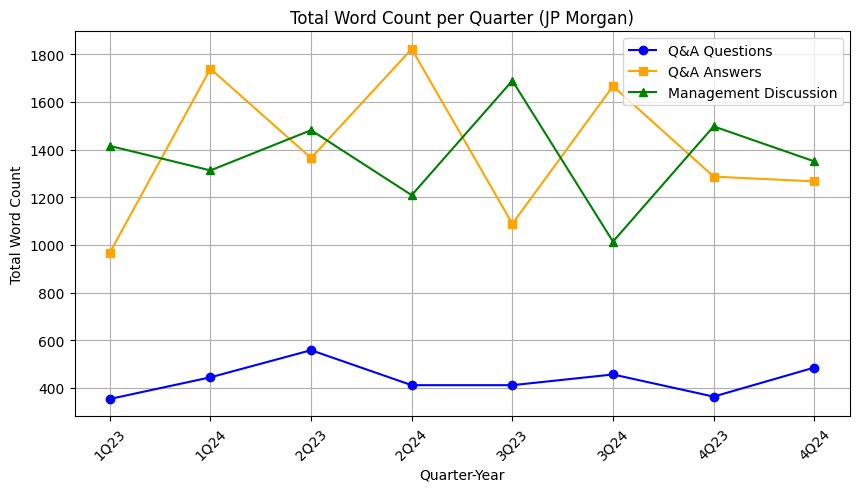

In [ ]:
# Check word count per quarter (Questions, Answers, Management)

qna_df = pd.read_csv(f"{BOE_path}/jpmorgan_qna_df_preprocessed_final.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_df_preprocessed_final.csv")

qna_df["question_word_count"] = qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split()))
qna_df["answer_word_count"] = qna_df["Answer_cleaned"].astype(str).apply(lambda x: len(x.split()))
management_df["text_word_count"] = management_df["Text_cleaned"].astype(str).apply(lambda x: len(x.split()))

qna_word_count = qna_df.groupby("Quarter-Year")[["question_word_count", "answer_word_count"]].sum().reset_index()
management_word_count = management_df.groupby("Quarter-Year")[["text_word_count"]].sum().reset_index()

# plot word count trends over time
plt.figure(figsize=(10, 5))
plt.plot(qna_word_count["Quarter-Year"], qna_word_count["question_word_count"], marker="o", label="Q&A Questions", color="blue")
plt.plot(qna_word_count["Quarter-Year"], qna_word_count["answer_word_count"], marker="s", label="Q&A Answers", color="orange")
plt.plot(management_word_count["Quarter-Year"], management_word_count["text_word_count"], marker="^", label="Management Discussion", color="green")
plt.xlabel("Quarter-Year")
plt.ylabel("Total Word Count")
plt.title("Total Word Count per Quarter (JP Morgan)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Breaking down Q&A into questions vs. answers reveals that answers are the primary driver of word count spikes rather than an increase in questions, **suggesting executives elaborated more in certain quarters rather than analysts asking more**.

# 4. Sentiment readiness check

Check for positive/negative words present, any potential biases in wording, check for extreme sentiment shifts (anomalies)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


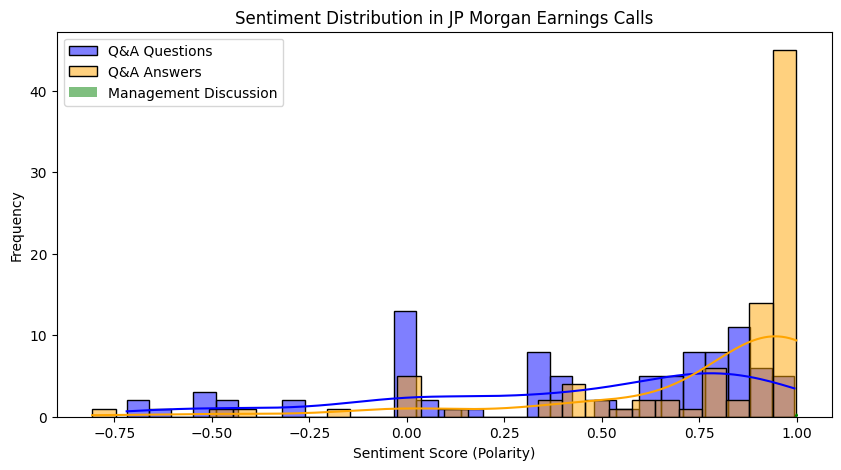

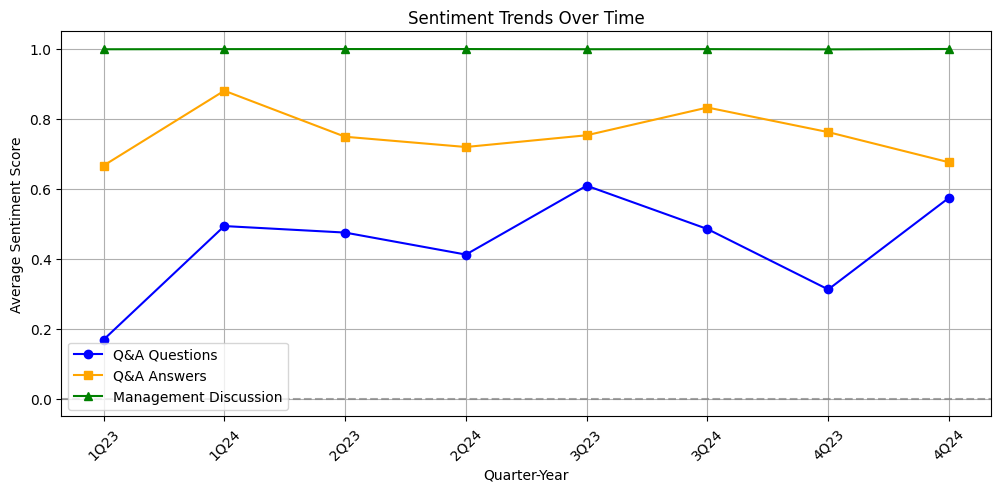


📌 Sentiment Summary Statistics:
Q&A Questions: count    91.000000
mean      0.439629
std       0.461576
min      -0.718400
25%       0.012900
50%       0.615100
75%       0.820050
max       0.993800
Name: question_sentiment, dtype: float64
Q&A Answers: count    91.000000
mean      0.753751
std       0.382273
min      -0.807000
25%       0.682350
50%       0.931300
75%       0.977750
max       0.998700
Name: answer_sentiment, dtype: float64
Management Discussion: count    8.000000
mean     0.999125
std      0.000365
min      0.998500
25%      0.998875
50%      0.999200
75%      0.999400
max      0.999600
Name: text_sentiment, dtype: float64


In [ ]:
# Compute sentiment scores and distribution (using Vader)

nltk.download('vader_lexicon')

qna_df = pd.read_csv(f"{BOE_path}/jpmorgan_qna_df_preprocessed_final.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_df_preprocessed_final.csv")

sia = SentimentIntensityAnalyzer()

# compute sentiment scores and apply sentiment analysis
def get_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)["compound"]
    return None

qna_df["question_sentiment"] = qna_df["Question_cleaned"].apply(get_sentiment)
qna_df["answer_sentiment"] = qna_df["Answer_cleaned"].apply(get_sentiment)
management_df["text_sentiment"] = management_df["Text_cleaned"].apply(get_sentiment)

# plot sentiment distribution
plt.figure(figsize=(10, 5))
sns.histplot(qna_df["question_sentiment"], bins=30, kde=True, label="Q&A Questions", color="blue", alpha=0.5)
sns.histplot(qna_df["answer_sentiment"], bins=30, kde=True, label="Q&A Answers", color="orange", alpha=0.5)
sns.histplot(management_df["text_sentiment"], bins=30, kde=True, label="Management Discussion", color="green", alpha=0.5)
plt.xlabel("Sentiment Score (Polarity)")
plt.ylabel("Frequency")
plt.title("Sentiment Distribution in JP Morgan Earnings Calls")
plt.legend()
plt.show()

# average sentiment per quarter
qna_sentiment_by_quarter = qna_df.groupby("Quarter-Year")[["question_sentiment", "answer_sentiment"]].mean()
management_sentiment_by_quarter = management_df.groupby("Quarter-Year")[["text_sentiment"]].mean()

plt.figure(figsize=(12, 5))
plt.plot(qna_sentiment_by_quarter.index, qna_sentiment_by_quarter["question_sentiment"], marker="o", label="Q&A Questions", color="blue")
plt.plot(qna_sentiment_by_quarter.index, qna_sentiment_by_quarter["answer_sentiment"], marker="s", label="Q&A Answers", color="orange")
plt.plot(management_sentiment_by_quarter.index, management_sentiment_by_quarter["text_sentiment"], marker="^", label="Management Discussion", color="green")
plt.axhline(0, linestyle="--", color="gray", alpha=0.7)
plt.xlabel("Quarter-Year")
plt.ylabel("Average Sentiment Score")
plt.title("Sentiment Trends Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# summary statistics
print("\n📌 Sentiment Summary Statistics:")
print("Q&A Questions:", qna_df["question_sentiment"].describe())
print("Q&A Answers:", qna_df["answer_sentiment"].describe())
print("Management Discussion:", management_df["text_sentiment"].describe())

- Management Discussion shows an overwhelmingly positive sentiment (near 1.0), with almost no variation, (this could be due to potential bias in VADER’s handling of corporate speech). Q&A sentiment is more balanced, with both positive and negative sentiment present, indicating greater emotional variation in analyst-executive interactions.

- Q&A Answers consistently have higher sentiment scores than Questions, suggesting executives frame responses more positively than analysts' inquiries. Questions show more sentiment variability, likely reflecting fluctuating analyst concerns across different quarters.

- Q&A Questions have a lower average sentiment (0.44) than Answers (0.75), reinforcing the idea that analysts ask tougher, more skeptical questions. Management Discussion’s near-uniform sentiment (~0.999) suggests that executives maintain an extremely polished, neutral-to-positive tone, which could distort sentiment analysis in future modeling.

💡**Q&A sentiment may be more useful for detecting shifts in market sentiment than Management Discussion**, since analysts asks more neutral-to-negative questions, while executives give consistently positive answers.

💡**Further modelling with e.g. FinBERT may be better than VADER** at finding true sentiment of management discussions within their formal, structured language.

💡**Topic modelling should account for analyst-driven themes highlighted by bigrams and trigrams** e.g. regulation, loan growth, risk, since these are recurrent concerns in Q&A.

💡**Sentiment trends could signal market shifts** - the volatility in Q&A sentiment suggests a potential link to macroeconomic events. Further modelling can track sentiment anomalies to detect early warning signals for financial discussions.



# 5. Speaker & Role-Based Analysis (Q&A only)




Who drives discussions, how does engagement vary per role, trends over time

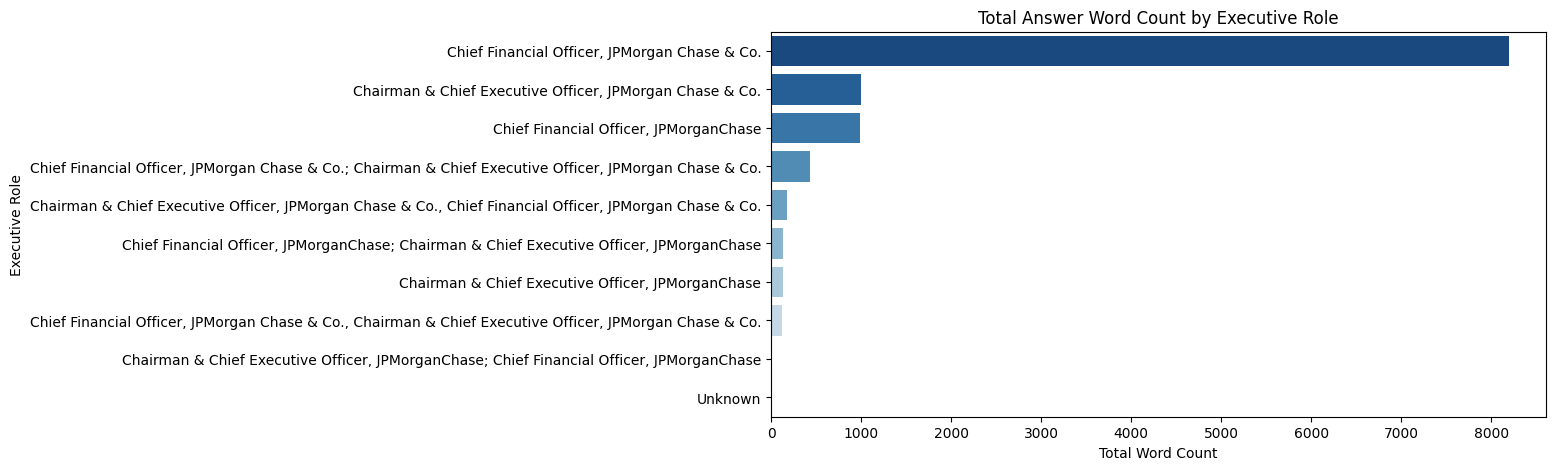

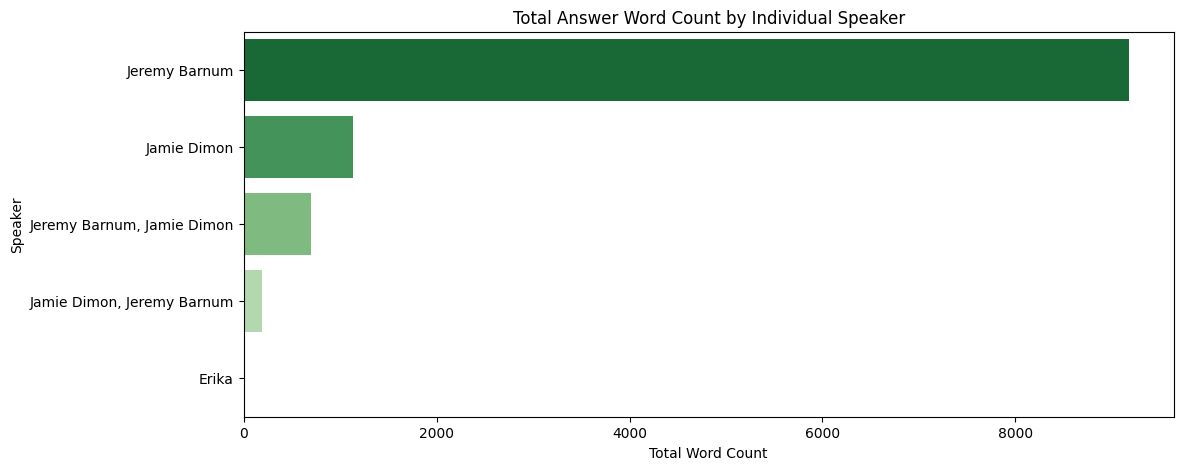

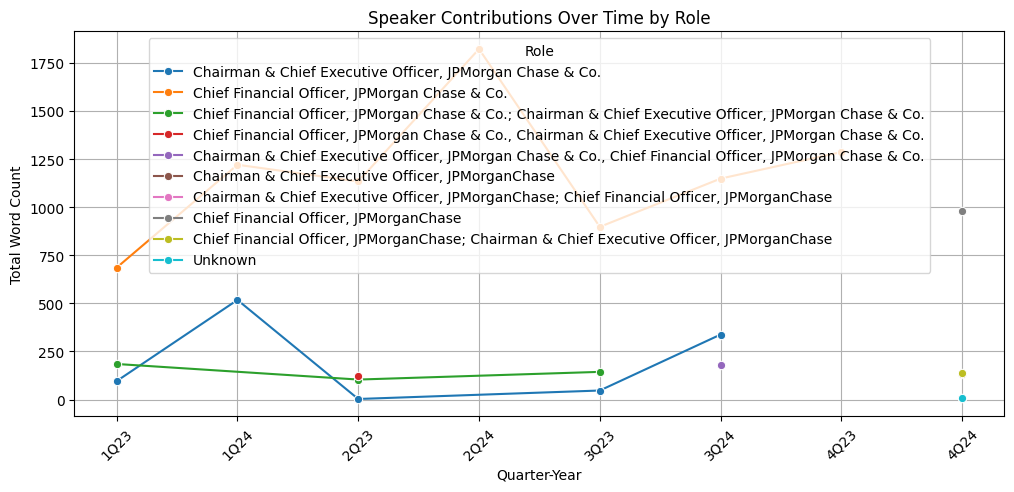

In [ ]:
# Compare word count by speaker role

qna_df = pd.read_csv(f"{BOE_path}/jpmorgan_qna_df_preprocessed_final.csv")

# word counts for questions and answers
qna_df["question_word_count"] = qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split()))
qna_df["answer_word_count"] = qna_df["Answer_cleaned"].astype(str).apply(lambda x: len(x.split()))

# compare total word count by role
role_word_count = qna_df.groupby("Role of the person answered the question")["answer_word_count"].sum().reset_index()
role_word_count = role_word_count.sort_values(by="answer_word_count", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="answer_word_count", y="Role of the person answered the question", data=role_word_count, hue="Role of the person answered the question", palette="Blues_r", legend=False)
plt.xlabel("Total Word Count")
plt.ylabel("Executive Role")
plt.title("Total Answer Word Count by Executive Role")
plt.show()

# compare total word count by individual speaker
speaker_word_count = qna_df.groupby("Answered By")["answer_word_count"].sum().reset_index()
speaker_word_count = speaker_word_count.sort_values(by="answer_word_count", ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x="answer_word_count", y="Answered By", data=speaker_word_count, hue="Answered By", palette="Greens_r", legend=False)
plt.xlabel("Total Word Count")
plt.ylabel("Speaker")
plt.title("Total Answer Word Count by Individual Speaker")
plt.show()

# word count trends by role over time
role_trends = qna_df.groupby(["Quarter-Year", "Role of the person answered the question"])["answer_word_count"].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=role_trends, x="Quarter-Year", y="answer_word_count", hue="Role of the person answered the question", marker="o")
plt.xlabel("Quarter-Year")
plt.ylabel("Total Word Count")
plt.title("Speaker Contributions Over Time by Role")
plt.xticks(rotation=45)
plt.legend(title="Role")
plt.grid()
plt.show()

- The CFO role consistently dominates word count, indicating that earnings discussions are more finance-driven than strategic compared to CEO-led commentary. Some joint responses, possibly when addressing complex analyst queries.
- CEO and CFO contributions fluctuate across quarters, suggesting shifts in leadership communication focus based on earnings performance or market conditions.
- 💡 The spike in 1Q24 and 3Q24 aligns with previous Q&A volume trends, reinforcing that certain executives are driving longer discussions in those periods.

❗**Inconsistent role formatting (e.g., different CFO/CEO label variations) suggests some standardization is needed for clearer trends analysis.**

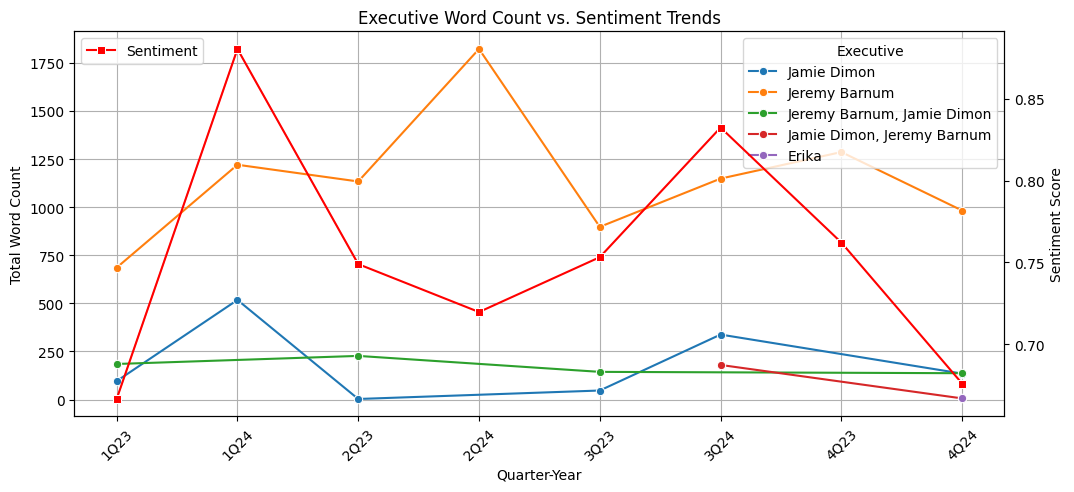

In [ ]:
# Cross check executive contributions with sentiment, Q&A length, and quarterly fluctuations

# get sentiment scores per quarter
sia = SentimentIntensityAnalyzer()
if "question_sentiment" not in qna_df.columns:
    qna_df["question_sentiment"] = qna_df["Question_cleaned"].astype(str).apply(lambda x: sia.polarity_scores(x)["compound"])
if "answer_sentiment" not in qna_df.columns:
    qna_df["answer_sentiment"] = qna_df["Answer_cleaned"].astype(str).apply(lambda x: sia.polarity_scores(x)["compound"])

qna_sentiment_by_quarter = qna_df.groupby("Quarter-Year")[["question_sentiment", "answer_sentiment"]].mean().reset_index()

# merge executive word count with sentiment data
speaker_word_count = qna_df.groupby(["Quarter-Year", "Answered By"])["answer_word_count"].sum().reset_index()
merged_df = speaker_word_count.merge(qna_sentiment_by_quarter, on="Quarter-Year", how="left")

# plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged_df, x="Quarter-Year", y="answer_word_count", hue="Answered By", marker="o", palette="tab10")
plt.xlabel("Quarter-Year")
plt.ylabel("Total Word Count")
plt.title("Executive Word Count vs. Sentiment Trends")
plt.xticks(rotation=45)
plt.grid()
plt.legend(title="Executive")

ax2 = plt.gca().twinx()
sns.lineplot(data=merged_df, x="Quarter-Year", y="answer_sentiment", color="red", marker="s", label="Sentiment", ax=ax2)
ax2.set_ylabel("Sentiment Score")
ax2.legend(loc="upper left")

plt.show()

- **Executives speak more when sentiment is high** (positive correlation between sentiment scores and executive word count in most quarters, peaks in sentiment coincide with high executive word counts, suggesting confidence-driven discussions in stronger financial periods - however there are cases where lower sentiment results in higher speech volume (e.g., 2Q24 CFO peak))
- **The CFO dominates the discussion**, especially when sentiment is low, possibly responding to financial concerns. **CEO** speech varies - he is more vocal in high-sentiment quarters but **less active in defensive discussions.**
- **2Q24 Anomaly** sentiment dips, but executive word count peaks (suggesting more defensive communication).


# 📔 Archive - EDA run on initial preprocessed data by Chiaki (13/02)

In [ ]:
# Load JPM preprocessed transcripts

files = os.listdir(BOE_path)

jp_morgan_files = [
    'jpmorgan_preprocessed_transcript.csv',
    'jpmorgan_management_discussion_preprocessed .csv',
    'jpmorgan_qa_section_preprocessed.csv',
    'unfiltered_preprocessed_JP_qa_sec.csv'
]

for file in jp_morgan_files:
    file_path = os.path.join(BOE_path, file)

    try:
        df = pd.read_csv(file_path, nrows=5)
        print(f"\n📌 **File: {file}**")
        print(df.columns.tolist())
    except Exception as e:
        print(f"\n⚠️ Could not read {file}: {e}")


📌 **File: jpmorgan_preprocessed_transcript.csv**
['filename', 'chunks', 'quarter', 'call_date']

📌 **File: jpmorgan_management_discussion_preprocessed .csv**
['filename', 'chunk_index', 'chunk_text', 'financial_quarter', 'call_date', 'tokenized_data', 'cleaned_data']

📌 **File: jpmorgan_qa_section_preprocessed.csv**
['speaker', 'marker', 'job_title', 'utterance', 'filename', 'financial_quarter', 'call_date', 'tokenised_data', 'cleaned_data']

📌 **File: unfiltered_preprocessed_JP_qa_sec.csv**
['speaker', 'marker', 'job_title', 'utterance', 'filename', 'financial_quarter', 'call_date']


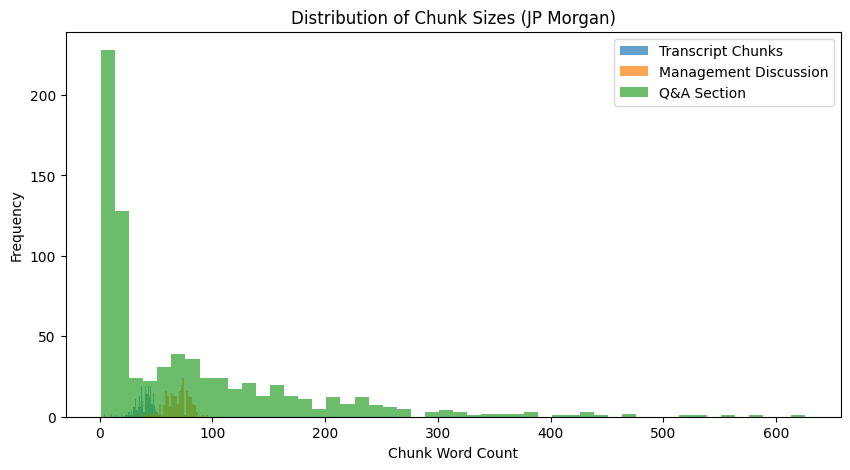

In [ ]:
# Calculate word count per chunk in each dataset

BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'
transcript_df = pd.read_csv(f"{BOE_path}/jpmorgan_preprocessed_transcript.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv") # loading file with space between final period
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

def calculate_word_counts(df, text_column):
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    return df

transcript_df = calculate_word_counts(transcript_df, 'chunks')
management_df = calculate_word_counts(management_df, 'chunk_text')
qa_df = calculate_word_counts(qa_df, 'utterance')

# Chunk Size Distribution (All Text)
plt.figure(figsize=(10,5))
plt.hist(transcript_df['word_count'], bins=50, alpha=0.7, label='Transcript Chunks')
plt.hist(management_df['word_count'], bins=50, alpha=0.7, label='Management Discussion')
plt.hist(qa_df['word_count'], bins=50, alpha=0.7, label='Q&A Section')
plt.xlabel("Chunk Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Chunk Sizes (JP Morgan)")
plt.legend()
plt.show()

Observation: **Inconsistent chunking** in Q&A with many short chunks (<50 words) suggesting fragmented responses, while longer chunks (up to 600+ words) are rare.


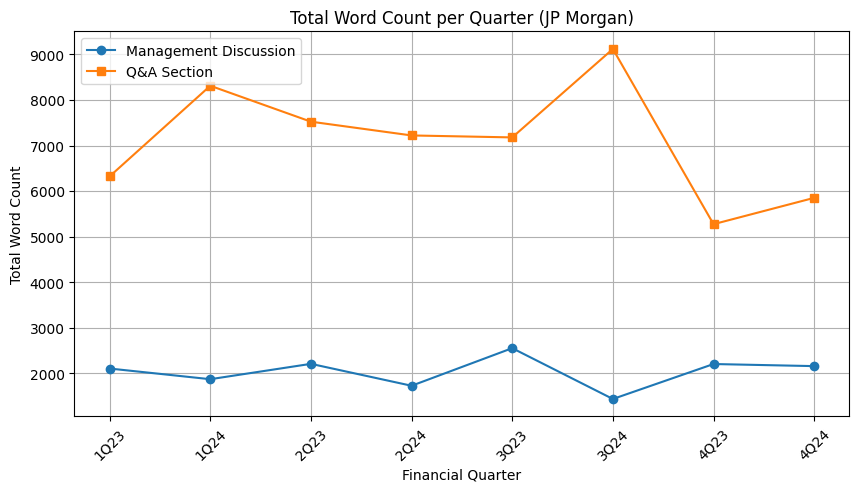

In [ ]:
# Get word count per quarter

management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv")
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

def compute_word_count(df, text_column, date_column):
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    return df.groupby(date_column)['word_count'].sum().reset_index()

management_word_count = compute_word_count(management_df, 'chunk_text', 'financial_quarter')
qa_word_count = compute_word_count(qa_df, 'utterance', 'financial_quarter')

plt.figure(figsize=(10, 5))
plt.plot(management_word_count['financial_quarter'], management_word_count['word_count'], marker='o', label='Management Discussion')
plt.plot(qa_word_count['financial_quarter'], qa_word_count['word_count'], marker='s', label='Q&A Section')

plt.xlabel("Financial Quarter")
plt.ylabel("Total Word Count")
plt.title("Total Word Count per Quarter (JP Morgan)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


Observation
- **Q&A Sections Are Significantly Longer** - Q&A word count consistently exceeds 6,000-9,000 words per quarter, while Management Discussion remains relatively stable (~1,500-3,000 words)
- **Q&A Section Shows More Volatility** - Noticeable Q&A peaks in 1Q24 and 3Q24 (8,000-9,000 words) followed by a sharp drop in 4Q23 (5,000 words)
- The small Management dip in 3Q24 followed by a slight rebound suggests a possible seasonal effect or reporting structure shift.

Action: Could consider separating trends by speaker roles in Q&A to understand if certain executives driving longer discussions, or if analysts are becoming more vocal. Could also compare with external events to see if the earnings were surprises or if there were market movements that cause longer Q&As.

**(I checked for macroeconomic events around the 3Q23 dip and there was economic stagnation in the UK (zero growth)  with elevated corporate borrowing rates, this could have driven shorter discussions due to limited new developments, and focus on cost management and cautious outlooks. Conversely, around the 3Q24 spike, there was global economic growth (2.52% growth) and monetary policy adjustments (reducing rates) which may have led to longer discussions)**

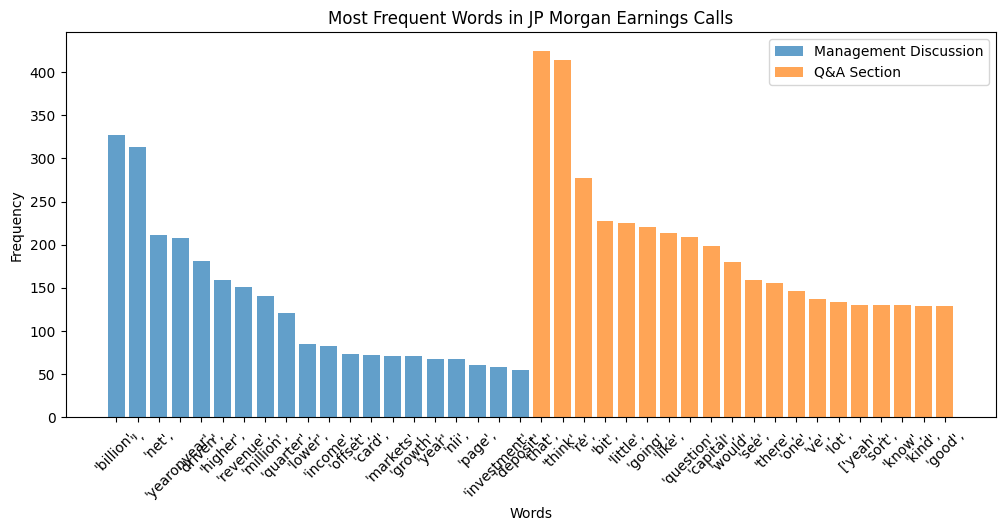

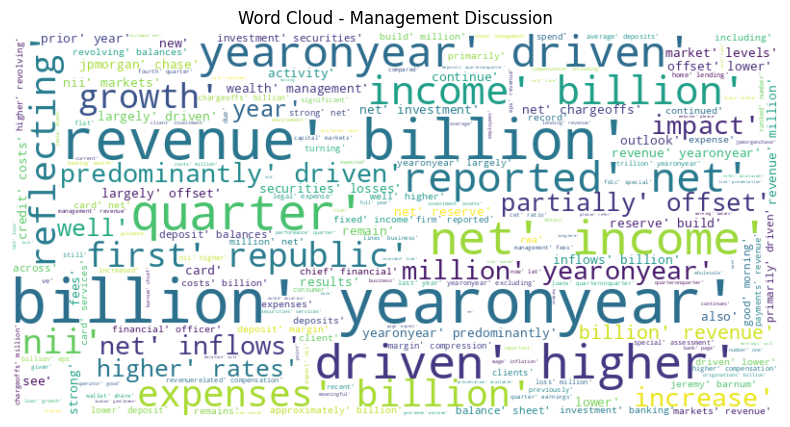

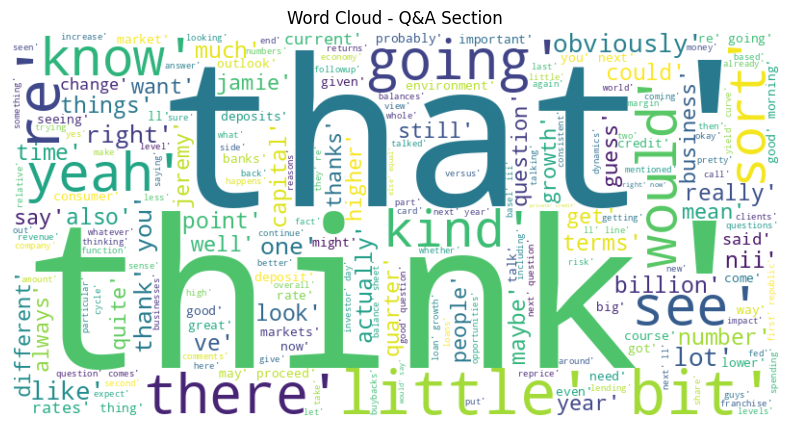

In [ ]:
# Word frequency with word cloud

management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv")
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

# had to add this as the columns are named slightly differently
text_column_mgmt = 'tokenized_data'
text_column_qa = 'tokenised_data'

def get_most_common_words(df, text_column, top_n=20):
    all_words = ' '.join(df[text_column].dropna()).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

top_words_management = get_most_common_words(management_df, text_column_mgmt)
top_words_qa = get_most_common_words(qa_df, text_column_qa)

df_management_words = pd.DataFrame(top_words_management, columns=['Word', 'Frequency'])
df_qa_words = pd.DataFrame(top_words_qa, columns=['Word', 'Frequency'])

# plot most common words
plt.figure(figsize=(12, 5))
plt.bar(df_management_words['Word'], df_management_words['Frequency'], alpha=0.7, label='Management Discussion')
plt.bar(df_qa_words['Word'], df_qa_words['Frequency'], alpha=0.7, label='Q&A Section')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in JP Morgan Earnings Calls")
plt.legend()
plt.show()

# plot word cloud for management discussion
wordcloud_mgmt = WordCloud(width=800, height=400, background_color='white').generate(' '.join(management_df[text_column_mgmt].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_mgmt, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Management Discussion")
plt.show()

# plot word cloud for Q&A section
wordcloud_qa = WordCloud(width=800, height=400, background_color='white').generate(' '.join(qa_df[text_column_qa].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_qa, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Q&A Section")
plt.show()

- Management Discussion is dominated by financial terms (e.g., billion, revenue, income, year-on-year)
- Q&A, due to a more conversational style, contains excessive filler words ("kind of", "little bit", "sort of"), indicating a need for improved stopword filtering to refine key insights.

**Action: Enhance stopword removal in Q&A to eliminate conversational clutter.**

Chunk Size Distribution – How long are the chunks? Are they too short or too long?

Word Count per Quarter – Does discussion length vary across quarters?

Comparison: Management Discussion vs Q&A – Are Q&A sections shorter or longer than management discussions?